## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('data\AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)


* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [3]:
from sklearn.model_selection import train_test_split


# data split
random_seed = 1
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=random_seed)
df_train, df_valid = train_test_split(df_train_full, test_size=0.25, random_state=random_seed)

# create target values for each split by log transforming the "price" column
y_train = np.log1p(df_train['price'].to_numpy())
y_valid = np.log1p(df_valid['price'].to_numpy())
y_test  = np.log1p(df_test['price'].to_numpy())
# important note: we need to transfer back target values later after inference prediction
# we use np.expm1() to do so

# don't forget to drop target column "price" from feature dataframes
del df_train['price']
del df_valid['price']
del df_test['price']

print(len(df), len(df_train), len(df_valid), len(df_test))


48895 29337 9779 9779


Now, use `DictVectorizer` to turn train and validation into matrices:

In [4]:
from sklearn.feature_extraction import DictVectorizer


dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_valid.to_dict(orient='records')
X_valid = dv.transform(val_dicts)

test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)


## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [5]:
# answer to question #1

from sklearn.tree import DecisionTreeRegressor


model_dt = DecisionTreeRegressor(max_depth=1)
model_dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=1)

Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

In [6]:
# answer to question #1 (continued)

from sklearn.tree import export_text


# print(export_text(model_dt, feature_names=dv.get_feature_names()))  # use this instead of below line if you have (sklearn < 1.0) installed
print(export_text(model_dt, feature_names=list(dv.get_feature_names_out())))


|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



The tree structure above makes it clear that __'room_type'__ feature is used for splitting the best model with depth=1; Also Note that among categorical values in this column, __'Entire home/apt'__ is better suited for the model tree with depth=1 (and obviously that is the chosen column).

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [7]:
# answer to question #2

from sklearn.ensemble import RandomForestRegressor


model_rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

In [8]:
# answer to question #2 (continued)

import math
from sklearn.metrics import mean_squared_error


y_pred = model_rf.predict(X_valid)

# we need to calculate the root of MSE value in order to have RMSE
rmse = math.sqrt(mean_squared_error(y_valid, y_pred))
print('Root Mean Squared Error:', round(rmse, 3))


Root Mean Squared Error: 0.462


The closest value to the actual calculated RMSE among the answers is: __0.459__

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [9]:
# answer to question #3

estimators = range(10, 210, 10)

scores = []
for estimator in estimators:
    model_rf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_valid)
    rmse = math.sqrt(mean_squared_error(y_valid, y_pred))
    scores.append((estimator, rmse))


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

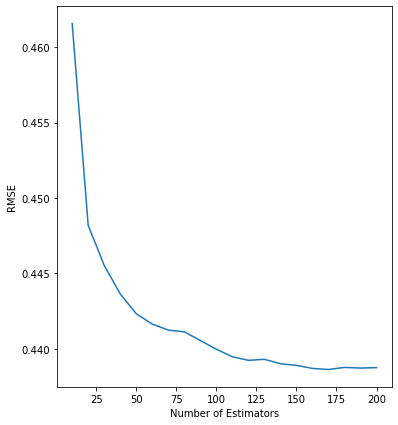

In [10]:
# answer to question #3 (continued)

scores_df = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

plt.figure(figsize=(6, 7))
plt.plot(scores_df['n_estimators'], scores_df['rmse'])
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.show()


Although overall RMSE seems to be improving, we can notice that around the approximate range of 120 to 130, RMSE does not improve (values are slighltly up). Therefore __120__ is the correct answer.

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [11]:
# answer to question #4

max_depth_values = [10, 15, 20, 25]
estimator_values = list(range(10, 210, 10))

scores = []
for max_depth in max_depth_values:
    for estimator in estimator_values:
        model_rf = RandomForestRegressor(n_estimators=estimator, max_depth=max_depth, random_state=1, n_jobs=-1)
        model_rf.fit(X_train, y_train)
        y_pred = model_rf.predict(X_valid)
        rmse = math.sqrt(mean_squared_error(y_valid, y_pred))
        scores.append((max_depth, estimator, rmse))


What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

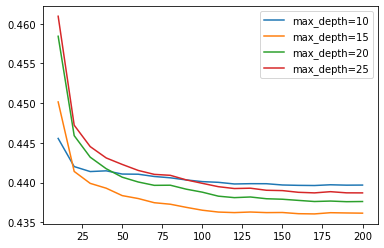

In [12]:
# answer to question #4 (continued)

scores_df = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

for max_depth in max_depth_values:
    df_subset = scores_df[scores_df['max_depth'] == max_depth]
    plt.plot(df_subset['n_estimators'], df_subset['rmse'], label=f"max_depth={max_depth}")

plt.legend()
plt.show()


It is obvious from the plot above that max_depth value of __15__ leads to lower (and better) RMSE values.<br>
Coming to the bonus question, I checked for two different random seeds (see below) and the result remained the same. __So, changing the random seed value does not change the outcome in this case.__

In [13]:
# answer to question #4 (continued)

def bonus_question(random_seed=None):
    max_depth_values = [10, 15, 20, 25]
    estimator_values = list(range(10, 210, 10))

    scores = []
    for max_depth in max_depth_values:
        for estimator in estimator_values:
            model_rf = RandomForestRegressor(n_estimators=estimator, max_depth=max_depth, random_state=random_seed, n_jobs=-1)
            model_rf.fit(X_train, y_train)
            y_pred = model_rf.predict(X_valid)
            rmse = math.sqrt(mean_squared_error(y_valid, y_pred))
            scores.append((max_depth, estimator, rmse))

    scores_df = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])
    for max_depth in max_depth_values:
        df_subset = scores_df[scores_df['max_depth'] == max_depth]
        plt.plot(df_subset['n_estimators'], df_subset['rmse'],
                label=f"max_depth={max_depth}")
    plt.legend()
    plt.show()


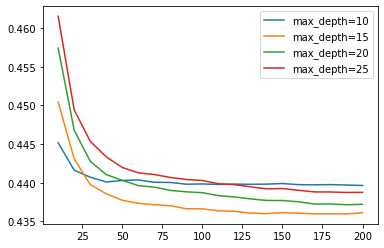

In [14]:
# answer to question #4 (continued)

bonus_question(random_seed=1589)

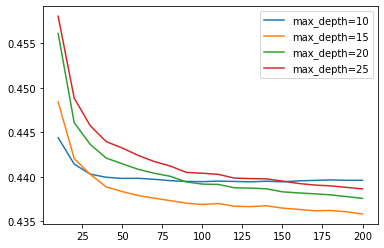

In [15]:
# answer to question #4 (continued)

bonus_question(random_seed=6813)

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [16]:
# answer to question #5

model_rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
model_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`
* `longitude`
* `latitude`

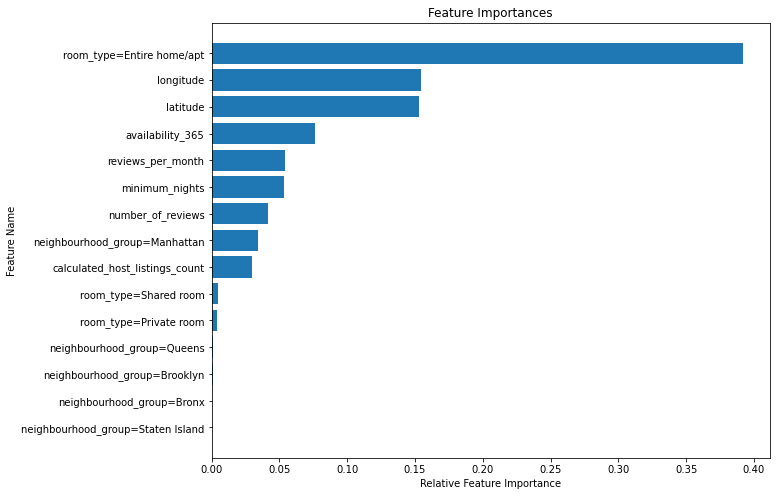

In [17]:
# answer to question #5 (continued)

feature_names = dv.feature_names_
importances = model_rf.feature_importances_
indices = np.argsort(importances)  # sorted indices of features based on importance value

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Feature Importance')
plt.ylabel('Feature Name')
plt.show()


Looking at above plot we see that the feature __"room_type=Entire home/apt"__ gets the highest relative importance value among all features for the specified random forest model.

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [18]:
# answer to question #6

import xgboost as xgb


# feature_names = dv.get_feature_names()  # use this instead of below line if you have (sklearn < 1.0) installed
feature_names = list(dv.get_feature_names_out())

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dvalid = xgb.DMatrix(X_valid, label=y_valid, feature_names=feature_names)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=100,
                      verbose_eval=5,
                      evals=watchlist)


[0]	train-rmse:3.02752	valid-rmse:3.02415
[5]	train-rmse:0.67490	valid-rmse:0.67752
[10]	train-rmse:0.43912	valid-rmse:0.44981
[15]	train-rmse:0.42259	valid-rmse:0.43827
[20]	train-rmse:0.41716	valid-rmse:0.43691
[25]	train-rmse:0.41365	valid-rmse:0.43621
[30]	train-rmse:0.40712	valid-rmse:0.43543
[35]	train-rmse:0.40444	valid-rmse:0.43510
[40]	train-rmse:0.40103	valid-rmse:0.43466
[45]	train-rmse:0.39723	valid-rmse:0.43371
[50]	train-rmse:0.39446	valid-rmse:0.43384
[55]	train-rmse:0.39129	valid-rmse:0.43378
[60]	train-rmse:0.38743	valid-rmse:0.43404
[65]	train-rmse:0.38421	valid-rmse:0.43450
[70]	train-rmse:0.38117	valid-rmse:0.43467
[75]	train-rmse:0.37801	valid-rmse:0.43489
[80]	train-rmse:0.37668	valid-rmse:0.43526
[85]	train-rmse:0.37259	valid-rmse:0.43537
[90]	train-rmse:0.36998	valid-rmse:0.43539
[95]	train-rmse:0.36742	valid-rmse:0.43579
[99]	train-rmse:0.36478	valid-rmse:0.43621


Now change `eta` first to `0.1` and then to `0.01`

In [19]:
# answer to question #6 (continued)

eta_values = [0.01, 0.1, 0.3]

xgb_scores = []
for eta in eta_values:
    evals_result = {}
    print(f'\nStarting training for eta {eta}:')
    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }

    model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=100,
                          verbose_eval=5,
                          evals=watchlist,
                          evals_result=evals_result)
    y_pred = model_xgb.predict(dvalid)
    rmse = math.sqrt(mean_squared_error(y_valid, y_pred))
    xgb_scores.append((eta, rmse, evals_result))



Starting training for eta 0.01:
[0]	train-rmse:4.25336	valid-rmse:4.25010
[5]	train-rmse:4.04779	valid-rmse:4.04454
[10]	train-rmse:3.85242	valid-rmse:3.84921
[15]	train-rmse:3.66674	valid-rmse:3.66359
[20]	train-rmse:3.49030	valid-rmse:3.48719
[25]	train-rmse:3.32263	valid-rmse:3.31956
[30]	train-rmse:3.16332	valid-rmse:3.16029
[35]	train-rmse:3.01196	valid-rmse:3.00898
[40]	train-rmse:2.86817	valid-rmse:2.86533
[45]	train-rmse:2.73158	valid-rmse:2.72884
[50]	train-rmse:2.60185	valid-rmse:2.59925
[55]	train-rmse:2.47865	valid-rmse:2.47612
[60]	train-rmse:2.36167	valid-rmse:2.35927
[65]	train-rmse:2.25061	valid-rmse:2.24835
[70]	train-rmse:2.14519	valid-rmse:2.14303
[75]	train-rmse:2.04514	valid-rmse:2.04311
[80]	train-rmse:1.95022	valid-rmse:1.94827
[85]	train-rmse:1.86015	valid-rmse:1.85833
[90]	train-rmse:1.77472	valid-rmse:1.77302
[95]	train-rmse:1.69373	valid-rmse:1.69214
[99]	train-rmse:1.63198	valid-rmse:1.63045

Starting training for eta 0.1:
[0]	train-rmse:3.87217	valid-rmse:

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

To answer this question, we need to check *"xgb_scores"* which we populated during training to find the lowest (and best) RMSE:

In [20]:
# answer to question #6 (continued)

for eta, rmse_score in [(item[0], item[1]) for item in xgb_scores]:
    print(f'eta: {eta} \t RMSE: {round(rmse_score, 4)}')


eta: 0.01 	 RMSE: 1.6305
eta: 0.1 	 RMSE: 0.4325
eta: 0.3 	 RMSE: 0.4362


__eta=0.1__ results in a lower (and better) RMSE score.<br>
We can also plot the RMSE values to get a visual confirmation:

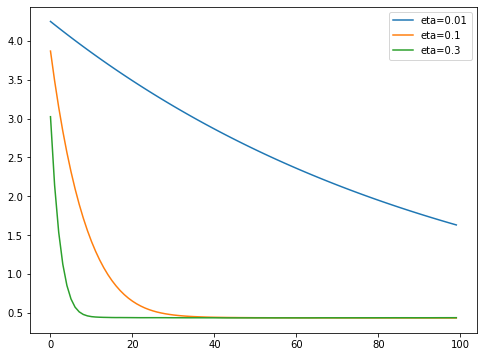

In [21]:
# answer to question #6 (continued)

plt.figure(figsize=(8, 6))
for eta, scores in zip(eta_values, [item[2]['valid']['rmse'] for item in xgb_scores]):
    plt.plot(scores, label=f"eta={eta}")

plt.legend()
plt.show()


Values for __eta=0.1__ and __eta=0.3__ are pretty close in later stages of training. We need to zoom-in to spot the better one:

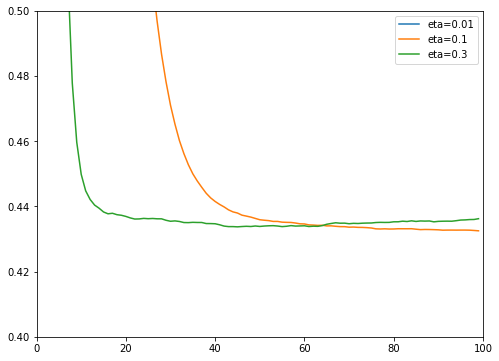

In [22]:
# answer to question #6 (continued)

plt.figure(figsize=(8, 6))
for eta, scores in zip(eta_values, [item[2]['valid']['rmse'] for item in xgb_scores]):
    plt.plot(scores, label=f"eta={eta}")

plt.legend()
plt.xlim(0, 100)
plt.ylim(0.4, 0.5)
plt.show()


As it is clear from above plot, eventually __eta=0.1__ leads to lower (and better) RMSE values. 